In [7]:
from probcal.models import GaussianNN
from probcal.data_modules import RotatedMNISTDataModule
from probcal.evaluation.calibration_evaluator import CalibrationResults
import torch
import matplotlib.pyplot as plt
import numpy as np
from properscoring import crps_gaussian

In [6]:
model = GaussianNN.load_from_checkpoint("chkp/rotated-mnist/gaussian/version_0/best_loss.ckpt")
device = torch.device("cuda")
dm = RotatedMNISTDataModule("data/rotated-mnist", batch_size=1024, num_workers=20, persistent_workers=True)
dm.prepare_data()
dm.setup("")

In [4]:
cce_results = CalibrationResults.load("results/rotated-mnist/gaussian/calibration_results.pt")

In [10]:
model = model.to(device)

mae_vals = []
nll_vals = []
crps_vals = []
variances = []
with torch.inference_mode():
    for images, labels in dm.test_dataloader():
        images = images.to(device)
        labels = labels.to(device)
        y_hat = model.predict(images)
        dist = model.predictive_dist(y_hat)
        mu, var = y_hat[:, 0].flatten(), y_hat[:, 1].flatten()
        variances.append(var)
        mae_vals.append((labels.flatten() - mu.flatten()).abs())
        crps_vals.append(torch.tensor(crps_gaussian(labels.flatten().cpu(), mu.cpu(), var.sqrt().cpu()), device=device))
        nll_vals.append(-dist.log_prob(labels.flatten()))

mae_vals = torch.cat(mae_vals)
crps_vals = torch.cat(crps_vals)
nll_vals = torch.cat(nll_vals)
variances = torch.cat(variances)

In [13]:
mae_vals.mean(), crps_vals.mean(), nll_vals.mean(), variances.mean()

(tensor(0.3192, device='cuda:0', dtype=torch.float64),
 tensor(0.2258, device='cuda:0', dtype=torch.float64),
 tensor(0.0778, device='cuda:0', dtype=torch.float64),
 tensor(0.8421, device='cuda:0'))

In [38]:
def get_mask_from_threshold(threshold: float, threshold_vals: torch.Tensor) -> tuple[torch.LongTensor, float]:
    mask = threshold_vals < threshold
    proportion_held_out = 1 - mask.float().mean().cpu().item()
    return mask, proportion_held_out

In [51]:
var_thresholds = torch.linspace(variances.min(), variances.max(), steps=5000)
var_mae = []
var_nll = []
var_crps = []
var_p = []

for threshold in var_thresholds:
    mask, p = get_mask_from_threshold(threshold, variances)
    var_p.append(p)
    var_mae.append(mae_vals[mask].mean())
    var_nll.append(nll_vals[mask].mean())
    var_crps.append(crps_vals[mask].mean())
    
var_p = torch.tensor(var_p).cpu()
var_mae = torch.tensor(var_mae).cpu()
var_nll = torch.tensor(var_nll).cpu()
var_crps = torch.tensor(var_crps).cpu()

In [52]:
cce_vals = cce_results.cce.expected_values
cce_thresholds = torch.linspace(cce_vals.min(), cce_vals.max(), steps=5000)
cce_mae = []
cce_nll = []
cce_crps = []
cce_p = []

for threshold in cce_thresholds:
    mask, p = get_mask_from_threshold(threshold, cce_vals)
    cce_p.append(p)
    cce_mae.append(mae_vals[mask].mean())
    cce_nll.append(nll_vals[mask].mean())
    cce_crps.append(crps_vals[mask].mean())
    
cce_p = torch.tensor(cce_p).cpu()
cce_mae = torch.tensor(cce_mae).cpu()
cce_nll = torch.tensor(cce_nll).cpu()
cce_crps = torch.tensor(cce_crps).cpu()

In [54]:
random_p_vals = torch.linspace(0, 1, steps=500)
n = len(mae_vals)

random_mae = []
random_nll = []
random_crps = []
random_p = []
for p in random_p_vals:
    mask = torch.randperm(n)[:int(p*n)]
    random_p.append(p)
    random_mae.append(mae_vals[mask].mean())
    random_nll.append(nll_vals[mask].mean())
    random_crps.append(crps_vals[mask].mean())

random_p = torch.tensor(random_p).cpu()
random_mae = torch.tensor(random_mae).cpu()
random_nll = torch.tensor(random_nll).cpu()
random_crps = torch.tensor(random_crps).cpu()

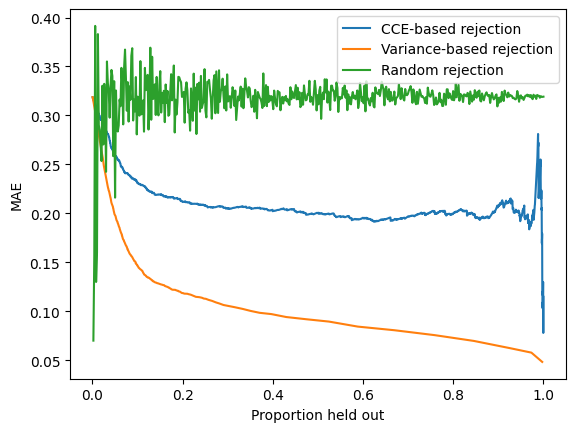

In [58]:
plt.plot(cce_p, cce_mae, label="CCE-based rejection")
plt.plot(var_p, var_mae, label="Variance-based rejection")
plt.plot(random_p, random_mae, label="Random rejection")
plt.legend()
plt.ylabel("MAE")
plt.xlabel("Proportion held out")
plt.show()

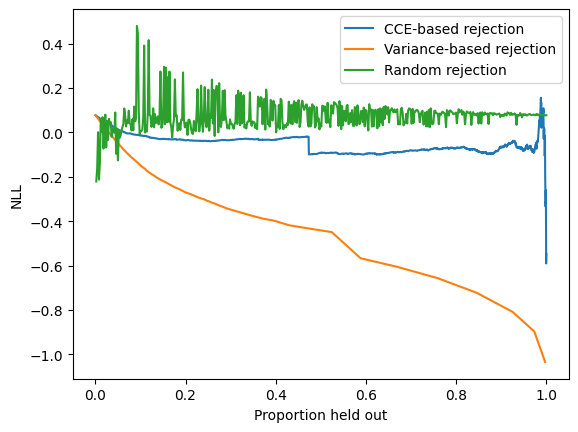

In [59]:
plt.plot(cce_p, cce_nll, label="CCE-based rejection")
plt.plot(var_p, var_nll, label="Variance-based rejection")
plt.plot(random_p, random_nll, label="Random rejection")
plt.legend()
plt.ylabel("NLL")
plt.xlabel("Proportion held out")
plt.show()

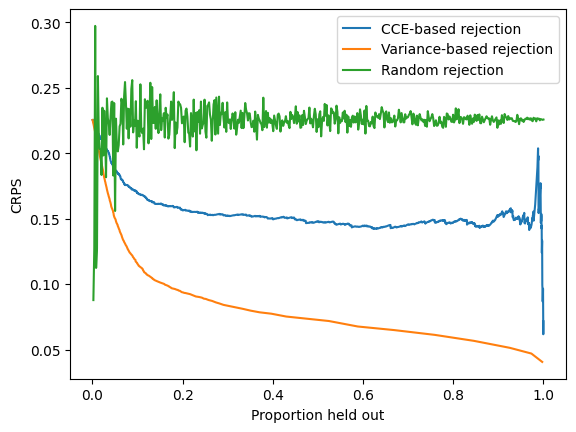

In [60]:
plt.plot(cce_p, cce_crps, label="CCE-based rejection")
plt.plot(var_p, var_crps, label="Variance-based rejection")
plt.plot(random_p, random_crps, label="Random rejection")
plt.legend()
plt.ylabel("CRPS")
plt.xlabel("Proportion held out")
plt.show()